In [1]:
import pandas as pd
import numpy as np
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm, tqdm_notebook

**DATA**

In [2]:
# Import and preprocess data
# Dropping the time, grouping by each patient and taking the mean for each feature to represent the patient data
x_train = pd.read_csv('train_features.csv').drop(['Time'], axis=1).groupby(by=['pid']).mean().sort_index()
x_test = pd.read_csv('test_features.csv').drop(['Time'], axis=1).groupby(by=['pid']).mean().sort_index()

y_train = pd.read_csv('train_labels.csv', index_col='pid').sort_index()


In [3]:
# Split labels into subtasks
y_train_subtask1 = y_train.iloc[:, 0:10]
y_train_subtask2 = y_train.iloc[:, 10]
y_train_subtask3 = y_train.iloc[:, 11:]

In [28]:
# Creating a DataFrame with all predictions for submission
predictions = pd.DataFrame(index=x_test.index, columns=y_train.columns)

In [8]:
x_train = pd.read_csv('train_features.csv', index_col='pid').sort_index()
x_test = pd.read_csv('test_features.csv', index_col='pid').sort_index()

y_train = pd.read_csv('train_labels.csv', index_col='pid').sort_index()


In [ ]:
# Fill NAN values with the most frequent value of the respective column
x_train.fillna(x_train.mode().iloc[0], inplace=True)
x_test.fillna(x_train.mode().iloc[0], inplace=True)

# Uncomment the next two lines, if you want to fill NAN values with the mean of the respective column
#x_train.fillna(x_train.mean(), inplace=True)
#x_test.fillna(x_train.mean().iloc[0], inplace=True)

In [11]:
def compute_features(data, n_samples):
    x = pd.DataFrame()
    features = {"median":np.nanmedian, "mean":np.nanmean, "var":np.nanvar, "min":np.nanmin, "max":np.nanmax}
    for index in tqdm(range(int(data.shape[0] / n_samples))):
        patient_data = data.iloc[n_samples * index:n_samples * (index + 1), 1:]
        patient_features = {}
        for col in data.columns[1:]:
            for feature in features.keys():
                patient_features[str(col+"_"+feature)] = features[feature](patient_data.loc[:, col])
        x = x.append(pd.DataFrame(patient_features, index=[patient_data.index[0]]))
    return x

In [12]:
x_train = compute_features(x_train, 12)

100%|██████████| 18995/18995 [07:28<00:00, 42.39it/s]


In [21]:
x_test = compute_features(x_test, 12)

100%|██████████| 12664/12664 [04:46<00:00, 44.15it/s]


In [22]:
x_train

,Age_median,Age_mean,Age_var,Age_min,Age_max,EtCO2_median,EtCO2_mean,EtCO2_var,EtCO2_min,EtCO2_max,...,ABPs_median,ABPs_mean,ABPs_var,ABPs_min,ABPs_max,pH_median,pH_mean,pH_var,pH_min,pH_max
1,34.0,34.0,0.0,34.0,34.0,32.0,32.0,0.0,32.0,32.0,...,111.0,114.500000,133.916667,100.0,142.0,7.380,7.374167,4.909722e-04,7.33,7.41
2,86.0,86.0,0.0,86.0,86.0,32.0,32.0,0.0,32.0,32.0,...,128.0,129.416667,94.909722,110.0,148.0,7.380,7.380000,7.888609e-31,7.38,7.38
4,66.0,66.0,0.0,66.0,66.0,32.0,32.0,0.0,32.0,32.0,...,120.0,124.166667,819.638889,86.0,168.0,7.380,7.380000,7.888609e-31,7.38,7.38
6,66.0,66.0,0.0,66.0,66.0,32.0,32.0,0.0,32.0,32.0,...,99.0,100.666667,30.555556,94.0,110.0,7.375,7.364167,3.909722e-04,7.33,7.39
8,42.0,42.0,0.0,42.0,42.0,32.0,32.0,0.0,32.0,32.0,...,206.5,196.666667,1306.722222,110.0,239.0,7.380,7.380000,7.888609e-31,7.38,7.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31653,52.0,52.0,0.0,52.0,52.0,32.0,32.0,0.0,32.0,32.0,...,103.0,98.666667,151.722222,75.0,110.0,7.380,7.371667,3.472222e-04,7.33,7.38
31654,66.0,66.0,0.0,66.0,66.0,32.0,32.0,0.0,32.0,32.0,...,160.0,160.416667,335.243056,110.0,187.0,7.380,7.380000,7.888609e-31,7.38,7.38
31656,44.0,44.0,0.0,44.0,44.0,32.0,32.0,0.0,32.0,32.0,...,103.0,101.916667,105.576389,88.0,120.0,7.380,7.353333,1.872222e-03,7.25,7.38
31657,70.0,70.0,0.0,70.0,70.0,32.0,32.0,0.0,32.0,32.0,...,109.5,110.416667,36.076389,101.0,124.0,7.380,7.380000,7.888609e-31,7.38,7.38


In [23]:
# Split the training data and labels into subsets in order to assess the performance of the model - but it's not ask for in the task
train_data, test_data, train_labels, test_labels = train_test_split(x_train, y_train, test_size=0.33, shuffle=True)
train_labels_subtask1 = train_labels.iloc[:, 0:10]
train_labels_subtask2 = train_labels.iloc[:, 10]
train_labels_subtask3 = train_labels.iloc[:, 11:]
test_labels_subtask1 = test_labels.iloc[:, 0:10]
test_labels_subtask2 = test_labels.iloc[:, 10]
test_labels_subtask3 = test_labels.iloc[:, 11:]

**PLOT DATA**

array([[<AxesSubplot:title={'center':'LABEL_BaseExcess'}>,
        <AxesSubplot:title={'center':'LABEL_Fibrinogen'}>,
        <AxesSubplot:title={'center':'LABEL_AST'}>,
        <AxesSubplot:title={'center':'LABEL_Alkalinephos'}>,
        <AxesSubplot:title={'center':'LABEL_Bilirubin_total'}>],
       [<AxesSubplot:title={'center':'LABEL_Lactate'}>,
        <AxesSubplot:title={'center':'LABEL_TroponinI'}>,
        <AxesSubplot:title={'center':'LABEL_SaO2'}>,
        <AxesSubplot:title={'center':'LABEL_Bilirubin_direct'}>,
        <AxesSubplot:title={'center':'LABEL_EtCO2'}>],
       [<AxesSubplot:title={'center':'LABEL_Sepsis'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

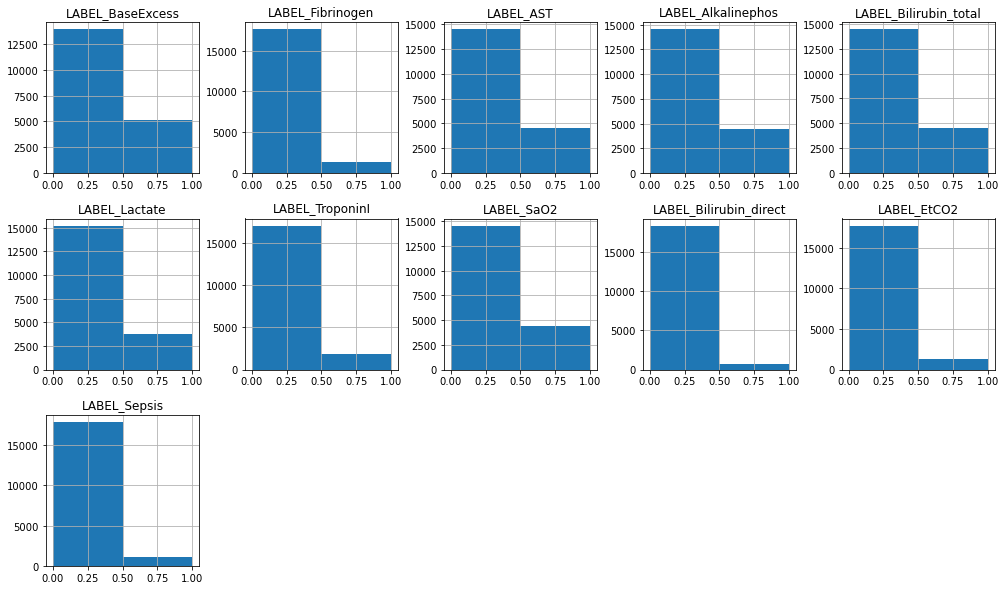

In [8]:
# Histogram plots of labels
# Due to highly imbalanced labels, under- and oversampling methods are applied afterwards to the training data
y_train.iloc[:, 0:11].hist(figsize=[17,10], layout=[3,5], bins=2)

In [9]:
# Percentage of label "1" occurring in each label set. These are just the numbers to contemplate the histogram plots from above. It's clear that the labels are highly imbalanced!
label_imb = pd.DataFrame(index=y_train.iloc[:, 0:11].columns, columns=['percentage of "1"'])
for i, column in enumerate(y_train.iloc[:, 0:11]):
    label_imb.iloc[i, 0] = round(y_train[column][y_train[column] == 1].count() / y_train.shape[0],3)
label_imb

,"percentage of ""1"""
LABEL_BaseExcess,0.268
LABEL_Fibrinogen,0.074
LABEL_AST,0.24
LABEL_Alkalinephos,0.236
LABEL_Bilirubin_total,0.241
LABEL_Lactate,0.2
LABEL_TroponinI,0.1
LABEL_SaO2,0.234
LABEL_Bilirubin_direct,0.034
LABEL_EtCO2,0.066


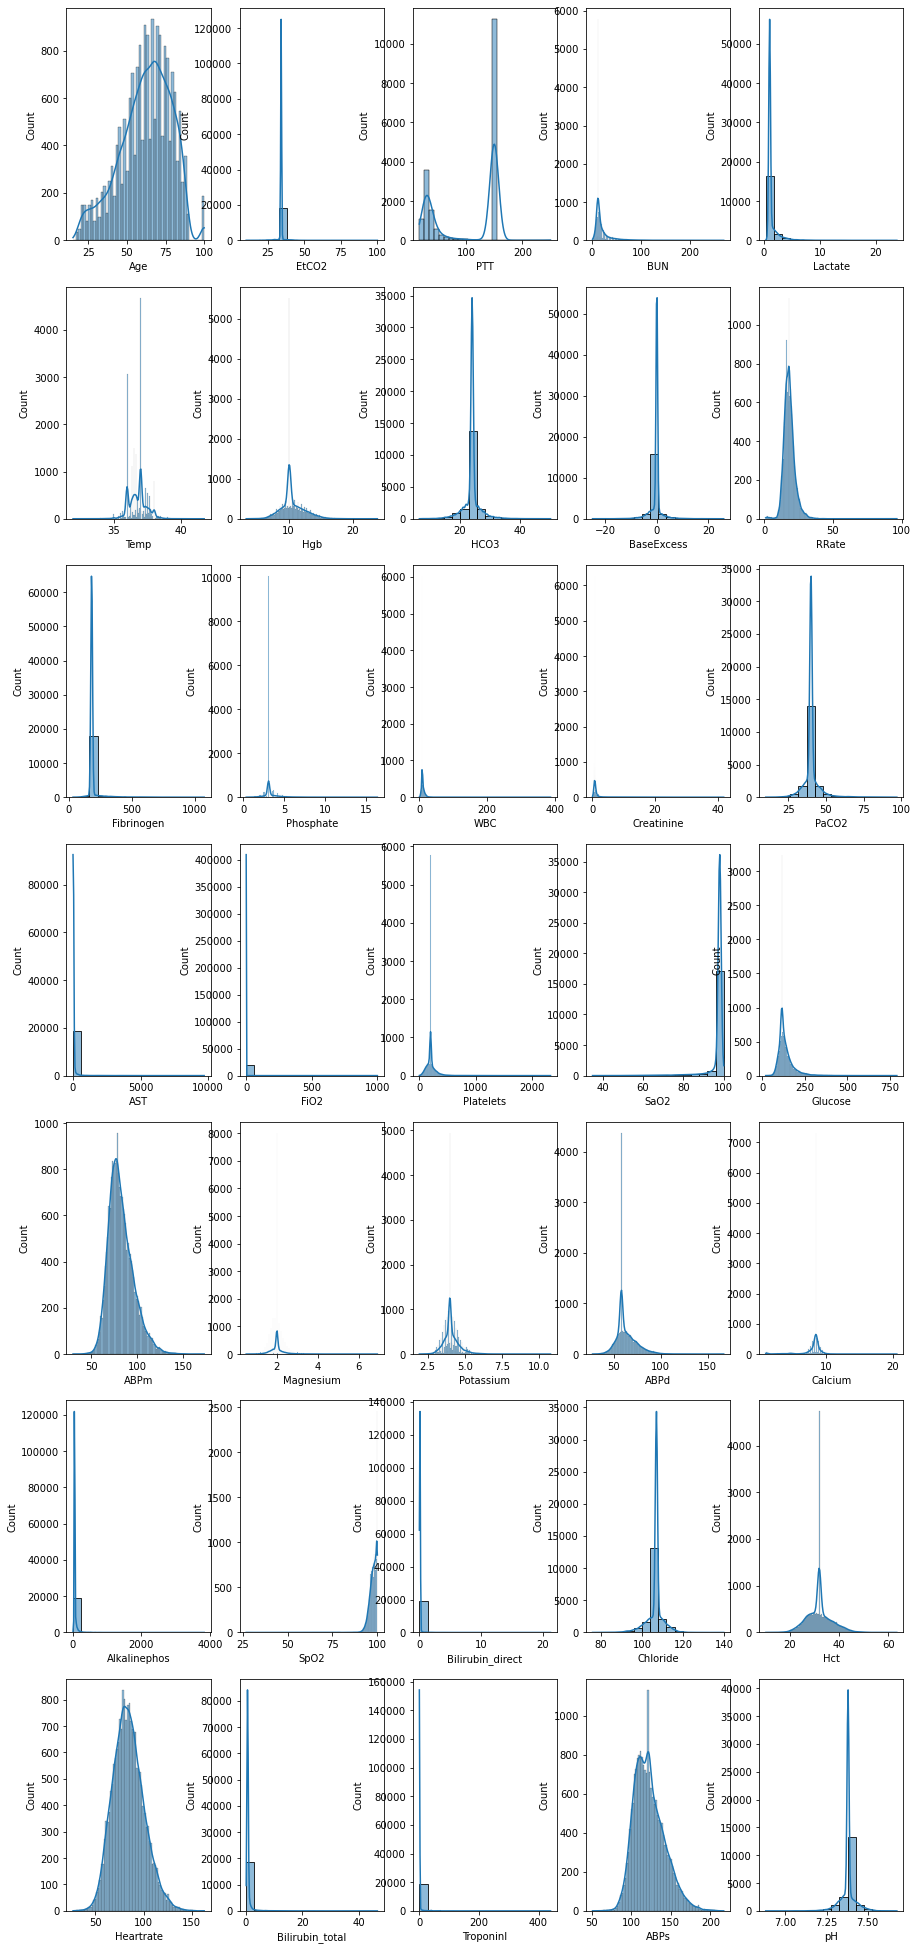

In [10]:
# !Computationally very expensive - takes about 5 minutes on my laptop!
# Distribution plots of every feature in order to assess best practice for filling NAN values
# Results are in general mono-modal - I suggest that one either takes the most frequent value or the mean as placeholder for NAN values.
fig, axes = plt.subplots(7, 5, figsize=(15,35))
for i, column in enumerate(x_train.columns):
    sns.histplot(x_train[column], ax=axes[i//5, i%5], kde=True)

**SUBTASK 1**

In [50]:
# Test performance on self-split data
# Defining model
model_1_cv = MultiOutputClassifier(RandomForestClassifier(random_state = np.random.seed(0)))

# Fitting model
param_grid = { 
    'estimator__n_estimators': [100, 200, 300, 500, 700],
    'estimator__max_features': ['auto', 'log2'],
    'estimator__max_depth' : [10, 15, 20],
    'estimator__criterion' :['gini']
}

CV_task1 = GridSearchCV(estimator=model_1_cv, param_grid=param_grid, cv= 5, scoring="roc_auc")
CV_task1.fit(train_data, train_labels_subtask1)

model_1_split = MultiOutputClassifier(RandomForestClassifier(random_state = np.random.seed(0)), **CV_task1.best_params_)
model_1_split.fit(train_data, train_labels_subtask1)

# Predicting labels
predictions_1_split = model_1_split.predict_proba(test_data)
pred_1_split = pd.DataFrame(index=test_data.index, columns=train_labels_subtask1.columns)
for i in range(len(predictions_1_split)):
    pred_1_split.iloc[:, i] = predictions_1_split[i][:,1]

# Scoring with "Area Under the Receiver Operating Characteristic Curve"
roc_auc_score(test_labels_subtask1, pred_1_split)


KeyboardInterrupt: 

In [24]:
# Defining RandomForestClassifier as the model - it shows according to literature good performance in the case of imbalanced classification
# Random seed was added for reproducibility
model_1 = MultiOutputClassifier(RandomForestClassifier(random_state = np.random.seed(0)), **CV_task1.best_params_)

In [25]:
# !Computationally expensive - takes about 1-2 minutes on my laptop!
# Fitting the model to the data
model_1.fit(x_train, y_train_subtask1)

MultiOutputClassifier(estimator=RandomForestClassifier())

In [26]:
# Predicting the probabilistic labels for the test data
predictions_1 = model_1.predict_proba(x_test)

In [29]:
# Adding the predictions of subtask 1 to the master prediction DataFrame
for i in range(len(predictions_1)):
    predictions.iloc[:, i] = predictions_1[i][:,1]
predictions.head(10)

,LABEL_BaseExcess,LABEL_Fibrinogen,LABEL_AST,LABEL_Alkalinephos,LABEL_Bilirubin_total,LABEL_Lactate,LABEL_TroponinI,LABEL_SaO2,LABEL_Bilirubin_direct,LABEL_EtCO2,LABEL_Sepsis,LABEL_RRate,LABEL_ABPm,LABEL_SpO2,LABEL_Heartrate
0,0.91,0.61,0.77,0.74,0.73,0.51,0.04,0.42,0.15,0.02,NaN,NaN,NaN,NaN,NaN
3,0.08,0.02,0.24,0.31,0.22,0.06,0.16,0.05,0.00,0.01,NaN,NaN,NaN,NaN,NaN
5,0.03,0.03,0.16,0.20,0.18,0.10,0.01,0.01,0.01,0.00,NaN,NaN,NaN,NaN,NaN
7,0.81,0.87,0.92,0.90,0.91,0.51,0.01,0.67,0.53,0.02,NaN,NaN,NaN,NaN,NaN
9,0.18,0.02,0.20,0.14,0.17,0.08,0.00,0.09,0.00,0.00,NaN,NaN,NaN,NaN,NaN
11,0.00,0.01,0.21,0.28,0.34,0.02,0.07,0.05,0.02,0.05,NaN,NaN,NaN,NaN,NaN
12,0.02,0.04,0.11,0.27,0.22,0.12,0.08,0.16,0.02,0.02,NaN,NaN,NaN,NaN,NaN
15,0.65,0.33,0.19,0.20,0.19,0.47,0.06,0.76,0.09,0.05,NaN,NaN,NaN,NaN,NaN
16,0.17,0.04,0.24,0.28,0.27,0.07,0.01,0.11,0.01,0.00,NaN,NaN,NaN,NaN,NaN
17,0.62,0.04,0.25,0.31,0.35,0.40,0.02,0.30,0.05,0.00,NaN,NaN,NaN,NaN,NaN


**SUBTASK 2**

In [15]:
# Test performance on self-split data
# Oversampling the minor class (in our case label "1") with SMOTE (Synthetic Minority Oversampling Technique)
over = SMOTE(sampling_strategy=0.1)
train_data_over, train_labels_subtask2_over = over.fit_resample(train_data, train_labels_subtask2)

# Undersampling the major class (in our case label "0") with RandomUnderSampler
under = RandomUnderSampler(sampling_strategy=0.5)
train_data_under_over, train_labels_subtask2_under_over = under.fit_resample(train_data_over, train_labels_subtask2_over)

# Defining RandomForestClassifier as the model
model_2_cv = RandomForestClassifier(random_state = np.random.seed(0))

param_grid = { 
    'n_estimators': [100, 150, 200, 250],
    'max_features': ['auto', 'log2'],
    'max_depth' : [8,10, 12, 14, 16],
    'criterion' :['gini']
}

CV_rfc = GridSearchCV(estimator=model_2_cv, param_grid=param_grid, cv= 5, scoring="roc_auc")
CV_rfc.fit(train_data_under_over, train_labels_subtask2_under_over)


# Defining mode
model_2_split = RandomForestClassifier(random_state = np.random.seed(0), **CV_rfc.best_params_)

# Fitting model
model_2_split.fit(train_data_under_over, train_labels_subtask2_under_over)

# Predicting labels
predictions_2_split = model_2_split.predict_proba(test_data)
pred_2_split = pd.Series(predictions_2_split[:,1], index=test_data.index, name=train_labels_subtask2.name).to_frame()

# Scoring with "Area Under the Receiver Operating Characteristic Curve"
roc_auc_score(test_labels_subtask2, pred_2_split)


0.722207372758659

In [16]:
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 16,
 'max_features': 'log2',
 'n_estimators': 100}

In [31]:
# Oversampling the minor class (in our case label "1") with SMOTE (Synthetic Minority Oversampling Technique)
over = SMOTE(sampling_strategy=0.1)
x_train_over, y_train_subtask2_over = over.fit_resample(x_train, y_train_subtask2)

# Undersampling the major class (in our case label "0") with RandomUnderSampler
under = RandomUnderSampler(sampling_strategy=0.5)
x_train_under_over, y_train_subtask2_under_over = under.fit_resample(x_train_over, y_train_subtask2_over)

In [32]:
model_2 = RandomForestClassifier(random_state = np.random.seed(0), **CV_rfc.best_params_)

In [33]:
# Fitting the model to the data
model_2.fit(x_train_under_over, y_train_subtask2_under_over)

RandomForestClassifier(max_depth=16, max_features='log2')

In [34]:
# Predicting the probabilistic labels for the test data
predictions_2 = model_2.predict_proba(x_test)

In [35]:
# Adding the predictions of subtask 2 to the master prediction DataFrame
predictions.iloc[:,10] = predictions_2[:,1]
predictions.head(10)

,LABEL_BaseExcess,LABEL_Fibrinogen,LABEL_AST,LABEL_Alkalinephos,LABEL_Bilirubin_total,LABEL_Lactate,LABEL_TroponinI,LABEL_SaO2,LABEL_Bilirubin_direct,LABEL_EtCO2,LABEL_Sepsis,LABEL_RRate,LABEL_ABPm,LABEL_SpO2,LABEL_Heartrate
0,0.91,0.61,0.77,0.74,0.73,0.51,0.04,0.42,0.15,0.02,0.517342,NaN,NaN,NaN,NaN
3,0.08,0.02,0.24,0.31,0.22,0.06,0.16,0.05,0.00,0.01,0.075704,NaN,NaN,NaN,NaN
5,0.03,0.03,0.16,0.20,0.18,0.10,0.01,0.01,0.01,0.00,0.065433,NaN,NaN,NaN,NaN
7,0.81,0.87,0.92,0.90,0.91,0.51,0.01,0.67,0.53,0.02,0.475280,NaN,NaN,NaN,NaN
9,0.18,0.02,0.20,0.14,0.17,0.08,0.00,0.09,0.00,0.00,0.204771,NaN,NaN,NaN,NaN
11,0.00,0.01,0.21,0.28,0.34,0.02,0.07,0.05,0.02,0.05,0.087680,NaN,NaN,NaN,NaN
12,0.02,0.04,0.11,0.27,0.22,0.12,0.08,0.16,0.02,0.02,0.257495,NaN,NaN,NaN,NaN
15,0.65,0.33,0.19,0.20,0.19,0.47,0.06,0.76,0.09,0.05,0.203758,NaN,NaN,NaN,NaN
16,0.17,0.04,0.24,0.28,0.27,0.07,0.01,0.11,0.01,0.00,0.351239,NaN,NaN,NaN,NaN
17,0.62,0.04,0.25,0.31,0.35,0.40,0.02,0.30,0.05,0.00,0.582588,NaN,NaN,NaN,NaN


**SUBTASK 3**

In [ ]:
# Test performance on self-split data
# Defining model
model_3_cv = MultiOutputClassifier(RandomForestClassifier(random_state = np.random.seed(0)))

# Fitting model
param_grid = { 
    'estimator__n_estimators': [100, 200, 300, 500, 700],
    'estimator__max_features': ['auto', 'log2'],
    'estimator__max_depth' : [10, 15, 20],
    'estimator__criterion' :['gini']
}

CV_task3 = GridSearchCV(estimator=model_3_cv, param_grid=param_grid, cv= 5, scoring="roc_auc")
CV_task3.fit(train_data, train_labels_subtask3)

# Test performance on self-split data
# Defining model
model_3_split = MultiOutputRegressor(RandomForestRegressor(random_state = np.random.seed(0)), **CV_task3.best_params_)

# Fitting model
model_3_split.fit(train_data, train_labels_subtask3)

# Predicting labels
pred_3_split = model_3_split.predict(test_data)

# Scoring with "R2"
r2_score(test_labels_subtask3, pred_3_split)

In [36]:
# Defining model
model_3 = MultiOutputRegressor(RandomForestRegressor(random_state=np.random.seed(0)), **CV_task3.best_params_)

In [37]:
# !Computationally expensive - takes about 2-3 minutes on my laptop!
# Fitting the model to the data
model_3.fit(x_train, y_train_subtask3)

MultiOutputRegressor(estimator=RandomForestRegressor())

In [38]:
# Predicting the means
predictions_3 = model_3.predict(x_test)

In [39]:
# Adding the predictions of subtask 3 to the master prediction DataFrame
predictions.iloc[:,11:] = predictions_3
predictions.head(10)

,LABEL_BaseExcess,LABEL_Fibrinogen,LABEL_AST,LABEL_Alkalinephos,LABEL_Bilirubin_total,LABEL_Lactate,LABEL_TroponinI,LABEL_SaO2,LABEL_Bilirubin_direct,LABEL_EtCO2,LABEL_Sepsis,LABEL_RRate,LABEL_ABPm,LABEL_SpO2,LABEL_Heartrate
0,0.91,0.61,0.77,0.74,0.73,0.51,0.04,0.42,0.15,0.02,0.517342,15.052000,85.651,98.404,86.588
3,0.08,0.02,0.24,0.31,0.22,0.06,0.16,0.05,0.00,0.01,0.075704,17.784540,82.252,96.686,91.717
5,0.03,0.03,0.16,0.20,0.18,0.10,0.01,0.01,0.01,0.00,0.065433,18.410000,73.258,95.704,65.720
7,0.81,0.87,0.92,0.90,0.91,0.51,0.01,0.67,0.53,0.02,0.475280,16.974081,87.755,97.883,91.055
9,0.18,0.02,0.20,0.14,0.17,0.08,0.00,0.09,0.00,0.00,0.204771,20.143000,89.827,96.099,94.951
11,0.00,0.01,0.21,0.28,0.34,0.02,0.07,0.05,0.02,0.05,0.087680,18.848000,92.442,96.528,79.722
12,0.02,0.04,0.11,0.27,0.22,0.12,0.08,0.16,0.02,0.02,0.257495,18.824000,90.164,95.118,92.507
15,0.65,0.33,0.19,0.20,0.19,0.47,0.06,0.76,0.09,0.05,0.203758,15.635000,82.893,96.595,84.058
16,0.17,0.04,0.24,0.28,0.27,0.07,0.01,0.11,0.01,0.00,0.351239,19.994000,82.868,97.634,91.141
17,0.62,0.04,0.25,0.31,0.35,0.40,0.02,0.30,0.05,0.00,0.582588,25.091000,76.106,96.956,91.395


**OUTPUT**

In [46]:
predictions.index.name = "pid"
predictions.to_csv('prediction.zip', index=True, float_format='%.3f', compression='zip')